<a href="https://colab.research.google.com/github/kwak9601/Qlearning_OpenAI/blob/main/q_learning_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import random
import itertools
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

learning_rate = 0.1
discount_factor = 0.6
epsilon = 0.2
num_episodes = 60

#state
range_temp = np.arange(200,700, 100) #[C] 5long
range_width = np.arange(6, 14, 2) #[mm]  4 long
range_height = np.arange(2, 4, 0.5) #[mm]  4 long  => 5x4x4 = 80
tup_states = (range_temp, range_width, range_height)

print(range_temp)
print(range_width)
print(range_height)
#Shows all the permutations of the state ranges
state_comb = list(itertools.product(range_temp, range_width, range_height))
print(state_comb)

# print(state_comb)

#action
range_wfs = np.arange(2, 3, 0.1)  # [m/min]
range_sod = np.arange(10, 13, 1)   # [mm]
range_tts = np.arange(25, 35, 2.5)  # [cm/min]
tup_actions = (range_wfs, range_sod, range_tts)

print(range_wfs)
print(range_sod)
print(range_tts)


#Shows all the permutations of the Action ranges
action_comb = list(itertools.product(range_wfs, range_sod, range_tts))

# random_action = [random.choice(range_wfs), random.choice(range_sod), random.choice(range_tts)]

desired_width = 10
desired_height = 3

[200 300 400 500 600]
[ 6  8 10 12]
[2.  2.5 3.  3.5]
[(200, 6, 2.0), (200, 6, 2.5), (200, 6, 3.0), (200, 6, 3.5), (200, 8, 2.0), (200, 8, 2.5), (200, 8, 3.0), (200, 8, 3.5), (200, 10, 2.0), (200, 10, 2.5), (200, 10, 3.0), (200, 10, 3.5), (200, 12, 2.0), (200, 12, 2.5), (200, 12, 3.0), (200, 12, 3.5), (300, 6, 2.0), (300, 6, 2.5), (300, 6, 3.0), (300, 6, 3.5), (300, 8, 2.0), (300, 8, 2.5), (300, 8, 3.0), (300, 8, 3.5), (300, 10, 2.0), (300, 10, 2.5), (300, 10, 3.0), (300, 10, 3.5), (300, 12, 2.0), (300, 12, 2.5), (300, 12, 3.0), (300, 12, 3.5), (400, 6, 2.0), (400, 6, 2.5), (400, 6, 3.0), (400, 6, 3.5), (400, 8, 2.0), (400, 8, 2.5), (400, 8, 3.0), (400, 8, 3.5), (400, 10, 2.0), (400, 10, 2.5), (400, 10, 3.0), (400, 10, 3.5), (400, 12, 2.0), (400, 12, 2.5), (400, 12, 3.0), (400, 12, 3.5), (500, 6, 2.0), (500, 6, 2.5), (500, 6, 3.0), (500, 6, 3.5), (500, 8, 2.0), (500, 8, 2.5), (500, 8, 3.0), (500, 8, 3.5), (500, 10, 2.0), (500, 10, 2.5), (500, 10, 3.0), (500, 10, 3.5), (500, 12, 2.0), (

In [45]:
#Function to mitigate extremely erroneous output width and height
def softner(value_to_near, obtained_geometrical_value):
    softened_value = obtained_geometrical_value - (value_to_near - obtained_geometrical_value)/5
    return softened_value

In [46]:
#equation for simulating next state given state action pair
#simulating environment
# transition_epsilon = 0.2

def mapping_eqn(state, action , isReset):
    global sum_reward, desired_width, desired_height

    next_temp = state[0] + 1.5 * action[0] - action[1]*20 - 0.3 * action[2] - 50          #vary as needed

    next_width = 10 + state[1]*0.1 + 0.01 * action[0] - 0.2 * action[1] - 0.003 * action[2]

    next_height = 2.5 + state[2]*0.1 + 0.01 * action[0] + 0.2 * action[1] - 0.004 * action[2]  
    
    
    volt = 20
    #wfs2 sod10 tts25
    
    next_temp = state[0] + 30 * action[0] *action[0] - action[1]*20 - 4 * action[2] + 130          #vary as needed
#     print('temp is', next_temp)
    
    next_width = 0.1*state[1] + (8.9462 + 1.8088 * action[0] - 0.3621 * action[2] + 0.1739 * volt 
    - 0.5008 * action[1] +0.003556 * action[2] * action[1] + 0.01667 * volt * action[1]
    - 0.1169 * action[0] * action[0] + 0.003137 * action[2] * action[2])
    
#     print('next width', next_width, 'next_height', next_height)
    
    next_height = 0.1*state[2] + (-0.3514 + 0.4818 * action[0] - 0.08477 * action[2] 
                   + 0.4028 * volt + 0.01431 * action[1]- 0.006146 * action[0] * action[2] 
                   + 0.001168 * action[2] * action[2] - 0.012463 * volt * volt)
    
    # do not want too extreme erroneous result
    # next_width = softner(desired_width, next_width)
    # next_height = softner(desired_height, next_height)
    
#     print('next temp is', next_temp)
#     print('next width is', next_width)
#     print('next_height is', next_height)
    
    #make copy

    actual_width = next_width
    actual_height = next_height
    
    reward_h = -abs(actual_height - desired_height)
    reward_w = -abs(actual_width - desired_width)
    
    reward = reward_h + reward_w
    
    if isReset == True:
        sum_reward = 0
        
    sum_reward += reward 
    
    if reward > -1:
        done = True
#         print('done is True')
    else:
        done = False
#     print('temp range', range_temp)
#     print('width range', range_width)
#     print('height range', range_height)
        
#     print('next temp, width and height is ', next_temp, next_width, next_height)
    
    #binning
    centers_temp = (range_temp[1:]+range_temp[:-1])/2
    next_temp = range_temp[np.digitize(next_temp, centers_temp)]
    
    centers_width = (range_width[1:]+range_width[:-1])/2
    next_width = range_width[np.digitize(next_width, centers_width)]
    
    centers_height = (range_height[1:]+range_height[:-1])/2
    next_height = range_height[np.digitize(next_height, centers_height)]
    
#     print('binned next temp is ', next_temp)
#     print('binned next width is ', next_width)
#     print('binned next height is ', next_height)

    
#     print('reward is', reward)
    

    
    tup_next_state = (next_temp, next_width, next_height)
    return tup_next_state, actual_width, actual_height, reward, sum_reward, done

In [47]:
average_over = 100
average_over_reward_list = []
average_over_count_list = []


for i in tqdm(range(average_over)):
    
    #Q table initialization
    # q_size = [len(range_temp) * len(range_width) * len(range_height), len(range_wfs) * len(range_sod) * len(range_tts)]
    q_size = [int(np.size(state_comb) / 3), int(np.size(action_comb) / 3)]
    # print(q_size) # 80*48 = 3840 emtries state x action
    q_table = np.random.uniform(low=-2, high=0, size=q_size )  #may adjust the high and low value initialization 
    # test_table = np.random.uniform(low=-1, high=0, size = [3,4])

    #     state = [random.choice(range_temp), random.choice(range_width), random.choice(range_height)]
    sum_reward = 0
    sum_reward_list = []
    iteration_count_list = []

    for episodes in range(num_episodes):

        state = random.choice(state_comb)

    #     print('index state is@@@@@@@@@@@@@@@@@@@@@@' , index_state)
    #     print('state is ', state)
    #     print(np.round(state, 1)) # round to 2 decimal. ** unsure why state_comb lends float values with small number at the end.

        done = False
        isReset = True
        iteration_count = 0 
        while not done:

            index_state = state_comb.index(state)
    #         print('on count number, ', count)
            if np.random.random() > epsilon: 

                #get greedy action from Q table
                index_action = np.argmax(q_table[index_state])
                #find corresponding action combination
                action = action_comb[index_action]

            else:
                #random action given state
                random_action = random.choice(action_comb)
                action = random_action
                index_action = action_comb.index(action)

            #use mapping_eqn and reward_eqn to grab new state and reward
            new_state, actual_w, actual_h, reward, sum_reward, done = mapping_eqn(state, action, isReset)
            isReset = False

            #^ tuple of states , numeric value

            if not done:
                #Maximum possible Q value in next step (for next state)
                max_future_q = np.max(q_table[state_comb.index(new_state)])  # [value of index of new-state]
                # Current Q value (for current state and performed action)
                current_q = q_table[index_state][index_action]

                # Equation for new Q value for current state and action pair.
                new_q = (1-learning_rate) * current_q + learning_rate * (reward + discount_factor * max_future_q)

                #Update q table with new q
                q_table[index_state][index_action] = new_q

            state = new_state 
            iteration_count += 1

        #create list for plotting
        iteration_count_list.append(iteration_count)
        sum_reward_list.append(sum_reward)

    average_over_reward_list.append(sum_reward_list)
    average_over_count_list.append(iteration_count_list)




final_average_over_reward_list = [sum(x)/len(x) for x in zip(*average_over_reward_list)]  
final_average_over_count_list = [sum(x)/len(x) for x in zip(*average_over_count_list)]    


    #     print(np.size(sum_reward_list))
    #             if -0.05 <= reward_eqn(state) <= 0:
    # #                 print('done = true')
    #                 done = True

    #     print('finished epsode #', episodes, 'with count', count)
    # print('end of code')

100%|██████████| 100/100 [00:02<00:00, 39.51it/s]


In [48]:
#for getting std dev for each run, for graphing purpose
average_over_reward_list_np = np.array(average_over_reward_list)
average_over_reward_list_np_std = np.std(average_over_reward_list_np, axis=0)
##
average_over_count_list_np = np.array(average_over_count_list)
average_over_count_list_np_std = np.std(average_over_count_list_np, axis=0)

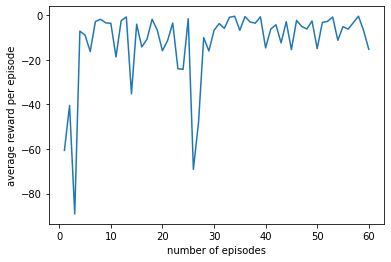

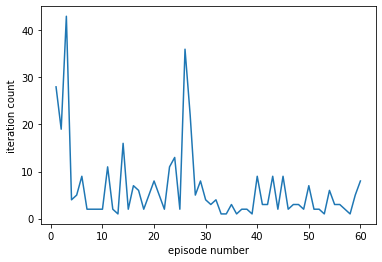

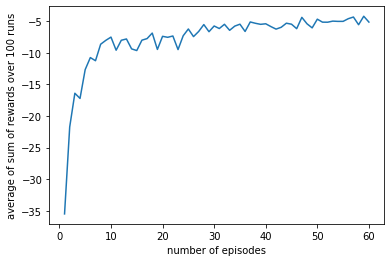

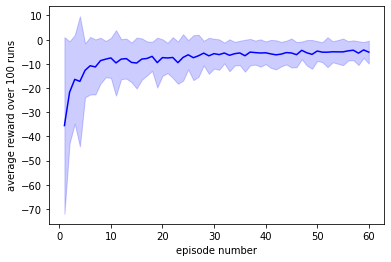

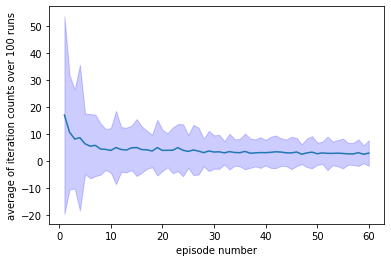

In [49]:
plt.plot(range(1,len(sum_reward_list)+1),sum_reward_list) # to start from episode 1 
plt.ylabel('average reward per episode')
plt.xlabel('number of episodes')
plt.show()

plt.plot(range(1,len(sum_reward_list)+1), iteration_count_list) # to start from episode 1 
plt.ylabel('iteration count')
plt.xlabel('episode number')
plt.show()
#iterations per episode

plt.plot(range(1,len(sum_reward_list)+1), final_average_over_reward_list) # to start from episode 1 
plt.ylabel('average of sum of rewards over ' + str(average_over) + ' runs')
plt.xlabel('number of episodes')
plt.show()

# Testing
plt.plot(range(1,len(sum_reward_list)+1), final_average_over_reward_list, 'b-', label='mean_F')
plt.fill_between(range(1,len(sum_reward_list)+1), final_average_over_reward_list - average_over_reward_list_np_std, final_average_over_reward_list + average_over_reward_list_np_std, color='b', alpha=0.2)
plt.ylabel('average reward over ' + str(average_over) + ' runs')
plt.xlabel('episode number')
plt.show()

plt.plot(range(1,len(sum_reward_list)+1), final_average_over_count_list) # to start from episode 1 

plt.fill_between(range(1,len(sum_reward_list)+1), final_average_over_count_list - average_over_reward_list_np_std, final_average_over_count_list + average_over_reward_list_np_std, color='b', alpha=0.2)

plt.ylabel('average of iteration counts over ' + str(average_over) + ' runs')
plt.xlabel('episode number')
plt.show()

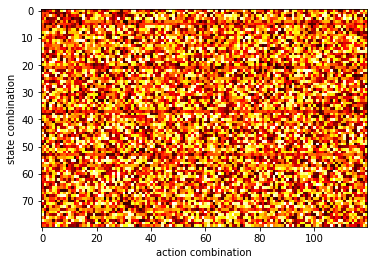

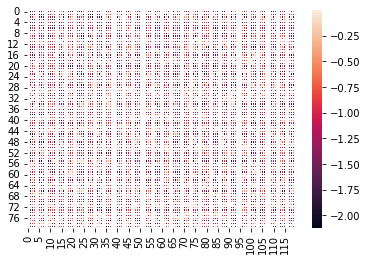

In [43]:
plt.imshow(q_table, cmap='hot', interpolation='nearest')
plt.xlabel("action combination")
plt.ylabel("state combination")
plt.show()
ax = sns.heatmap(q_table, linewidth=0.5)
plt.show()

In [ ]:
testlist = [[1,2,3], [5,6,7]]
a = [sum(x)/len(x) for x in zip(*testlist)]
print(a)


[3.0, 4.0, 5.0]
